In [1]:
import numpy as np 
import pandas as pd 
import cv2
from PIL import Image 
import os
import pathlib
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.applications import InceptionResNetV2

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
sess_config = tf.compat.v1.ConfigProto(gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.7), allow_soft_placement = True)
sess = tf.compat.v1.Session(config=sess_config)
tf.compat.v1.keras.backend.set_session(sess)

In [2]:
IMG_WIDTH=300
IMG_HEIGHT=300
IMG_DIM = (IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 10
IMG_DIR = pathlib.Path('G:\Github\standford-dogs\cropped')
TRAIN_DIR = 'G:/Github/standford-dogs/cropped/train'
VAL_DIR = 'G:/Github/standford-dogs/cropped/validation'

In [3]:
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Specify the values for all arguments to data_generator_with_aug.
# add zoom and vertical flip -> dogs are dogs no matter it is position and facing
data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                              horizontal_flip = True,
                                              width_shift_range = 0.2,
                                              height_shift_range = 0.2,
                                                zoom_range = 0.3, 
                                             vertical_flip = True
                                                )
            
data_generator_no_aug = ImageDataGenerator(preprocessing_function=preprocess_input)


In [4]:
train_generator = data_generator_with_aug.flow_from_directory(
                                        directory=TRAIN_DIR,
                                        target_size=IMG_DIM,
                                        batch_size=BATCH_SIZE,
                                        class_mode='categorical')

validation_generator = data_generator_no_aug.flow_from_directory(
                                        directory=VAL_DIR,
                                        target_size=IMG_DIM,batch_size=BATCH_SIZE,
                                        class_mode='categorical')


nb_train = len(train_generator.filenames)
nb_val = len(validation_generator.filenames)

Found 18522 images belonging to 120 classes.
Found 2058 images belonging to 120 classes.


In [5]:
from tensorflow.keras.models import Model
import tensorflow.keras as keras

resnet = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT,IMG_WIDTH,3),pooling='avg')

output = resnet.layers[-1].output
output = tf.keras.layers.Flatten()(output)
resnet = Model(resnet.input, output)


In [6]:
res_name = []
for layer in resnet.layers:
    res_name.append(layer.name)

In [7]:
res_name[-447:]

['block17_4_mixed',
 'block17_4_conv',
 'block17_4',
 'block17_4_ac',
 'conv2d_93',
 'batch_normalization_93',
 'activation_93',
 'conv2d_94',
 'batch_normalization_94',
 'activation_94',
 'conv2d_92',
 'conv2d_95',
 'batch_normalization_92',
 'batch_normalization_95',
 'activation_92',
 'activation_95',
 'block17_5_mixed',
 'block17_5_conv',
 'block17_5',
 'block17_5_ac',
 'conv2d_97',
 'batch_normalization_97',
 'activation_97',
 'conv2d_98',
 'batch_normalization_98',
 'activation_98',
 'conv2d_96',
 'conv2d_99',
 'batch_normalization_96',
 'batch_normalization_99',
 'activation_96',
 'activation_99',
 'block17_6_mixed',
 'block17_6_conv',
 'block17_6',
 'block17_6_ac',
 'conv2d_101',
 'batch_normalization_101',
 'activation_101',
 'conv2d_102',
 'batch_normalization_102',
 'activation_102',
 'conv2d_100',
 'conv2d_103',
 'batch_normalization_100',
 'batch_normalization_103',
 'activation_100',
 'activation_103',
 'block17_7_mixed',
 'block17_7_conv',
 'block17_7',
 'block17_7_ac',


In [8]:
set_trainable = False
for layer in resnet.layers:
    if layer.name in res_name[-447:]:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [9]:
resnet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout

num_classes = 120

model = Sequential()
model.add(resnet)
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 1536)              54336736  
_________________________________________________________________
dense (Dense)                (None, 1024)              1573888   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 120)               123000    
Total params: 57,083,224
Trainable params: 48,604,088
Non-trainable params: 8,479,136
____________________________________

In [11]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Include the epoch in the file name (uses `str.format`)
checkpoint_path = 'G:/Github/Dogs_breed_classification/Incepresnetv2_4/checkpoint/cp-{epoch:04d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights every epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq='epoch')


early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,
                                              restore_best_weights=False
                                              )


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                   factor=0.3,
                                   patience=5,
                                   verbose=1,
                                   min_delta=1e-3,min_lr = 1e-7,
                                   )

In [12]:
model.compile(optimizer = adam, 
              loss = 'categorical_crossentropy', 
              metrics=['accuracy',tfa.metrics.F1Score(num_classes=num_classes)])

In [13]:
model.fit(train_generator,steps_per_epoch=np.ceil(float(nb_train) / float(BATCH_SIZE)),
                        epochs = 100,callbacks=[cp_callback,early_stop,reduce_lr],
                          validation_steps=np.ceil(float(nb_val) / float(BATCH_SIZE)),
                        validation_data = validation_generator)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1853.0 steps, validate for 206.0 steps
Epoch 1/100
1853/1853 [==============================] - 547s 295ms/step - loss: 2.5825 - accuracy: 0.3706 - f1_score: 0.3638 - val_loss: 1.3271 - val_accuracy: 0.6744 - val_f1_score: 0.6416
Epoch 2/100
1853/1853 [==============================] - 491s 265ms/step - loss: 1.4478 - accuracy: 0.5965 - f1_score: 0.5904 - val_loss: 0.8343 - val_accuracy: 0.7566 - val_f1_score: 0.7372
Epoch 3/100
1853/1853 [==============================] - 492s 266ms/step - loss: 1.1484 - accuracy: 0.6665 - f1_score: 0.6617 - val_loss: 0.8375 - val_accuracy: 0.7687 - val_f1_score: 0.7497
Epoch 4/100
1853/1853 [==============================] - 490s 265ms/step - loss: 0.9830 - accuracy: 0.7129 - f1_score: 0.7077 - val_loss: 0.8295 - val_accuracy: 0.7672 - val_f1_score: 0.7533
Epoch 5/100
1853/1853 [==============================] - 500s 270ms/step - loss: 0.8821 - accuracy: 0.7361 - f1_score: 0.7315 - val_loss:

In [14]:
def get_diagnostic_plot(model,name):
    training_loss = model.history.history[name]
    test_loss = model.history.history[f'val_{name}']

    # Create count of the number of epochs
    epoch_count = range(1, len(training_loss) + 1)

    # Visualize loss history
    plt.plot(epoch_count, training_loss, 'r--')
    plt.plot(epoch_count, test_loss, 'b-')
    plt.legend([f'Training {name}', f'Val {name}'])
    plt.xlabel('Epoch')
    plt.ylabel(name)

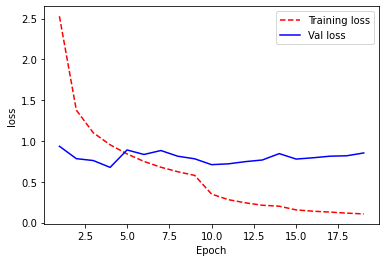

In [15]:
get_diagnostic_plot(model,'loss')

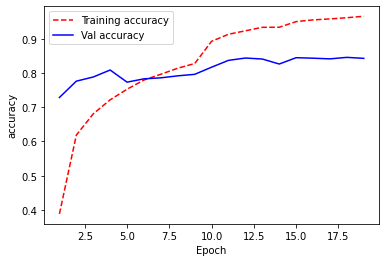

In [16]:
get_diagnostic_plot(model,'accuracy')

In [17]:
save_path = 'G:/Github/Dogs_breed_classification/Incepresnetv2_4/'
tf.keras.models.save_model(model,save_path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: G:/Github/Dogs_breed_classification/Incepresnetv2_4/assets


I think this is the best we have so far no?

We can probably repeat the process to improve further but it would take time and effort definitely

In [18]:
f1_score_history = model.history.history['f1_score']
f1_scores = [np.mean(item) for item in  f1_score_history]
f1_score_val_hist = model.history.history['val_f1_score']
f1_scores_val = [np.mean(item) for item in  f1_score_val_hist]

Text(0, 0.5, 'F1 Score')

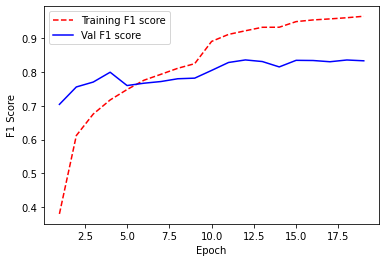

In [19]:
training_loss = f1_scores
test_loss = f1_scores_val

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

    # Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training F1 score', 'Val F1 score'])
plt.xlabel('Epoch')
plt.ylabel('F1 Score')

In [20]:
new_model = tf.keras.models.load_model(save_path)

In [15]:
save_path = 'G:/Github/Dogs_breed_classification/Incepresnetv2_5/'
model.save_weights(save_path)

InvalidArgumentError: Failed to create a directory: G:/Github/Dogs_breed_classification/Incepresnetv2_5/cp-{epoch:04d}.ckpt_temp_982c6ff8ff55453ba1e89ebb0d61ae3f; Invalid argument [Op:SaveV2]